<a href="https://colab.research.google.com/github/jithamanyu001/CV/blob/main/DeepDream_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from google.colab.patches import cv2_imshow

In [2]:
file_path=tf.keras.utils.get_file("labby","https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Labrador_on_Quantock_%282175262184%29.jpg/1200px-Labrador_on_Quantock_%282175262184%29.jpg")

277246/277246 [==============================] - 0s 0us/step


In [3]:
file_path

'/root/.keras/datasets/labby'

In [8]:
model=vgg16.VGG16(include_top=False)
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [9]:
outputs={
    "block2_conv2":1.0,
    "block3_conv3":1.0, 
    "block4_conv3":2.0
}
output_dict=dict(
    [
        (layer.name,layer.output)
        for layer in [model.get_layer(name) for name in outputs]
    ]
)
features=tf.keras.Model(inputs=model.input,outputs=output_dict)

In [10]:
def calc_loss(img):
  feats=features(img)
  loss=tf.zeros(())
  for i in feats:
    scaling=tf.reduce_prod(tf.cast(tf.shape(feats[i]),"float32"))
    loss += outputs[i]*tf.reduce_sum(tf.square(feats[i])) / scaling
  return loss

In [11]:
@tf.function()
def grad_ascent(img,lr):
  with tf.GradientTape() as tape:
    tape.watch(img)
    loss=calc_loss(img)
  grads=tape.gradient(loss,img)
  grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
  img += lr*grads
  return loss,img
def grad_ascent_loop(img,iters,lr,max_loss=None):
  for i in range(iters):
    loss,img=grad_ascent(img,lr)
    if max_loss is not None and loss>max_loss:
      break
    print(f"the loss : {loss}")
  return img


In [12]:
import numpy as np
def preprocess(file_path):
  img=tf.keras.utils.load_img(file_path)
  img=tf.keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img=vgg16.preprocess_input(img)
  return img


In [13]:
original_img = preprocess(file_path)/255.0
original_shape = original_img.shape[1:3]
num_octave = 3  
octave_scale = 1.4
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes=successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = grad_ascent_loop(
        img, 20, 0.01
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

Processing octave 0 with shape (403, 612)
the loss : 84.12620544433594
the loss : 104.3550796508789
the loss : 125.239013671875
the loss : 146.41458129882812
the loss : 168.06846618652344
the loss : 190.12686157226562
the loss : 212.54571533203125
the loss : 235.36614990234375
the loss : 258.4972839355469
the loss : 282.12493896484375
the loss : 306.0420837402344
the loss : 330.3780212402344
the loss : 355.0736083984375
the loss : 380.2216796875
the loss : 405.6519775390625
the loss : 431.666748046875
the loss : 458.0361328125
the loss : 484.906494140625
the loss : 512.0145874023438
the loss : 539.8621826171875
Processing octave 1 with shape (565, 857)
the loss : 311.626708984375
the loss : 346.3634033203125
the loss : 377.8177490234375
the loss : 407.80523681640625
the loss : 437.2349548339844
the loss : 466.3973693847656
the loss : 495.66937255859375
the loss : 525.152099609375
the loss : 554.9884033203125
the loss : 585.281005859375
the loss : 616.1687622070312
the loss : 647.642761

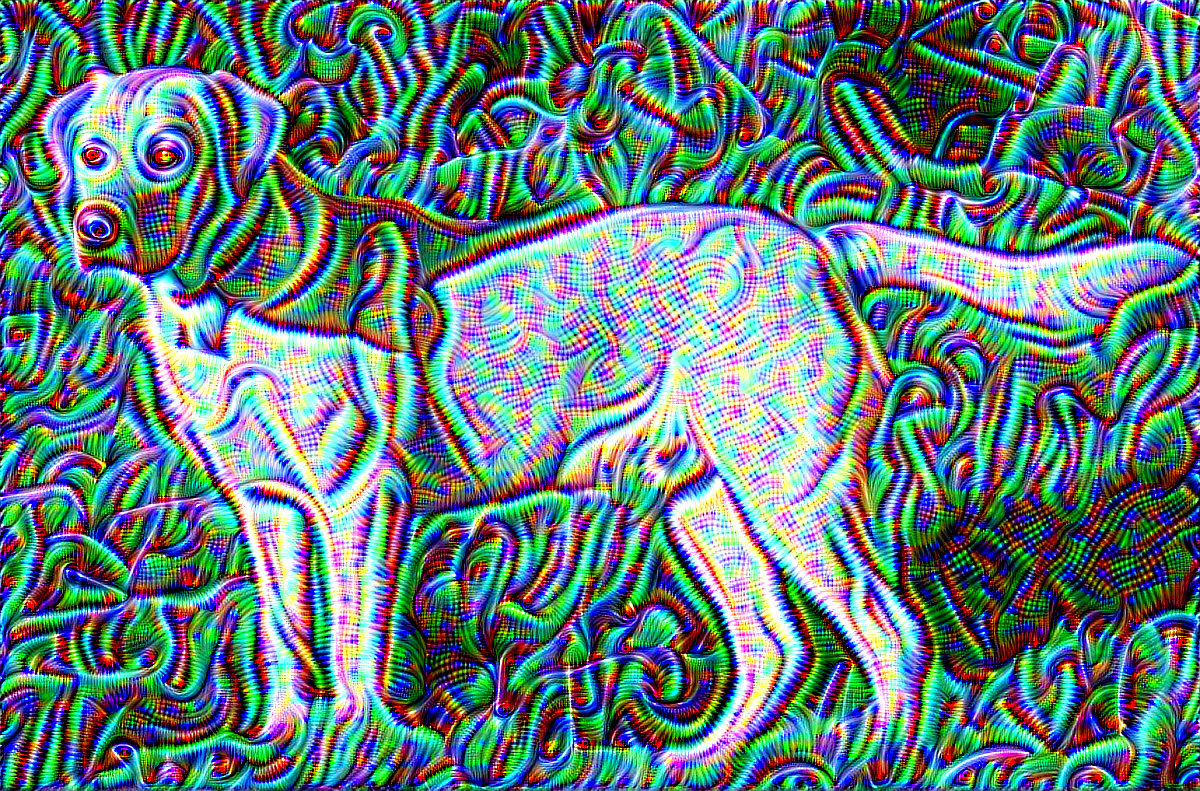

In [20]:
def restore_original_image_from_array(x, data_format='channels_first'):
    mean = [103.939, 116.779, 123.68]
    x=x*255.0
    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x
cv2_imshow(restore_original_image_from_array(np.array(img)[0],None))